In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import select_significant_areas, create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000.npy', 
                                   allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [4]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [5]:
df_levels = upls.create_df_levels(volumes)

# Analysis on number of cells

In [6]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [7]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


# TODOs: 
1) grandezza nodi per fold change

2) PLS e fare ranking delle saliences

3) Grafi da aree PLS

4) Grafi con le aree anticorrelate (X)

5) Correlazione e grafi con energia da confrontare con grafi n cellule

6) Grafi con layout spring

## Graphs of positive correlations

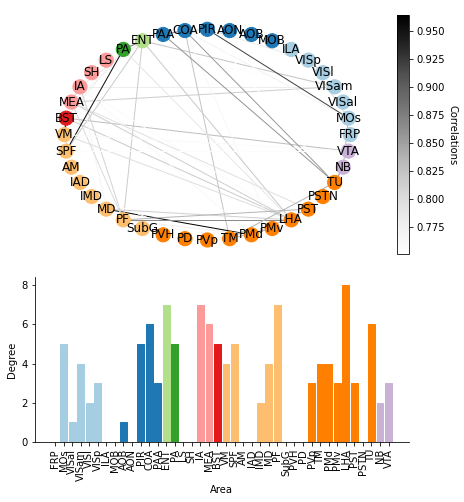

In [8]:
fig_graph_degrees(G=G_control, title='', volumes=volumes, show_legend=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/c57_WOF/graphs_ncells_ttest_control_c57WOF.eps')

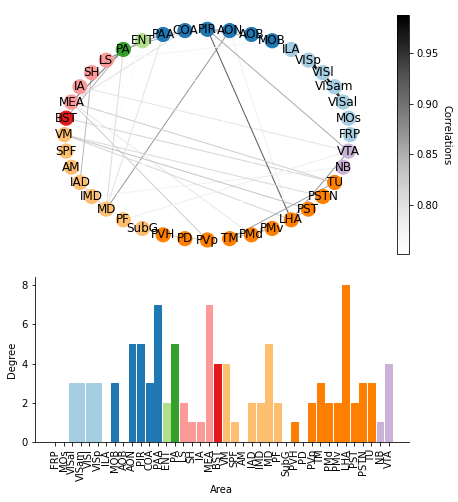

In [9]:
fig_graph_degrees(G=G_fam, title='', volumes=volumes, show_colorbar=True, show_legend=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/c57_WOF/graphs_ncells_ttest_fam_c57WOF.eps')

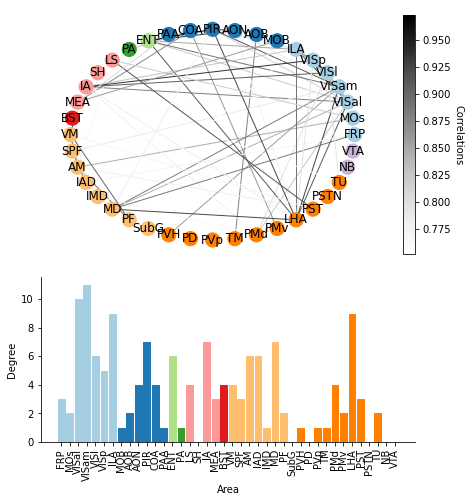

In [10]:
fig_graph_degrees(G=G_unfam, title='', volumes=volumes, show_colorbar=True, show_legend=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/c57_WOF/graphs_ncells_ttest_unfam_c57WOF.eps')

## Using Spring layout

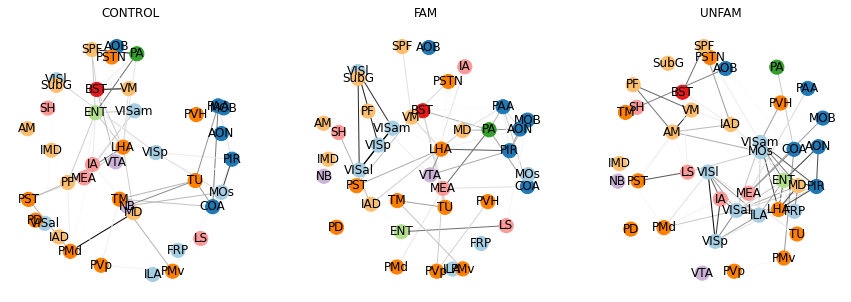

In [11]:
show_colorbar=True
show_legend=True
Gs = [G_control, G_fam, G_unfam]
titles=['CONTROL', 'FAM', 'UNFAM']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes)

# create figure
fig = plt.figure(figsize=(15, 5))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=1, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes)[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=12, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


## Histogram degrees

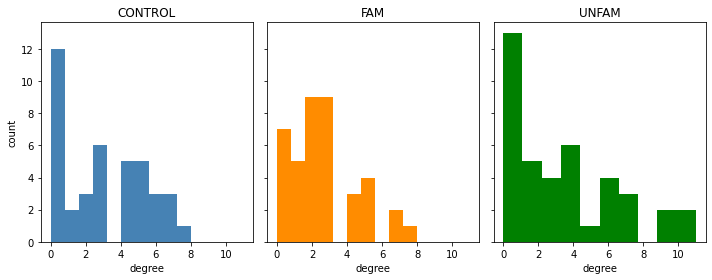

In [12]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='darkorange')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.png')

Text(0, 0.5, 'Degree')

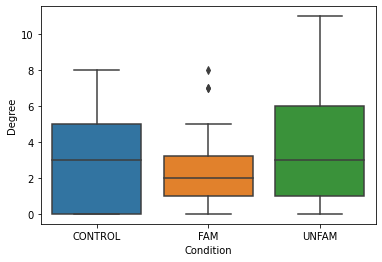

In [13]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control.degree).values()), 
                           'FAM': list(dict(G_fam.degree).values()), 
                           'UNFAM':list(dict(G_unfam.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

In [14]:
control_dg= np.histogram(list(dict(G_control.degree).values()), 
                            bins=50)[1]
fam_dg = np.histogram(list(dict(G_fam.degree).values()), 
                            bins=50)[1]
unfam_dg = np.histogram(list(dict(G_unfam.degree).values()), 
                            bins=50)[1]

stats.kstest(rvs=control_dg, cdf=fam_dg), stats.kstest(rvs=control_dg, cdf=unfam_dg), stats.kstest(rvs=fam_dg, cdf=unfam_dg)

(KstestResult(statistic=0.0, pvalue=1.0),
 KstestResult(statistic=0.27450980392156865, pvalue=0.042388771873188597),
 KstestResult(statistic=0.27450980392156865, pvalue=0.042388771873188597))

## Histogram weights

Text(0.5, 0.98, 'Correlation distribution of significant areas')

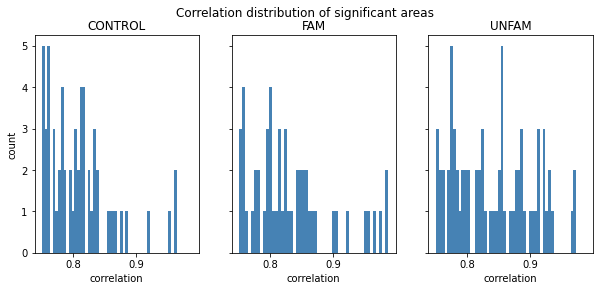

In [15]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control, G_fam, G_unfam]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue', bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlation distribution of significant areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.png')

## Overall correlations

Text(0.5, 0.98, 'Correlations of all areas')

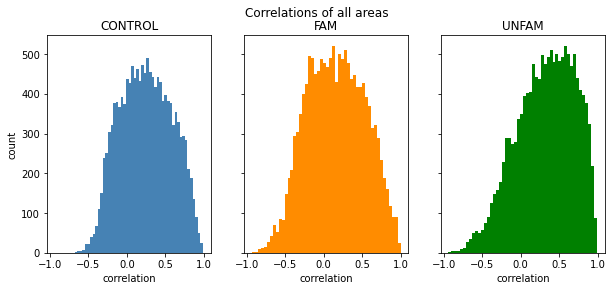

In [16]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_ncells, 
                          corr_matrix_fam_ncells, 
                          corr_matrix_unfam_ncells]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.png')

In [17]:
control_dist = np.histogram(corr_matrix_control_ncells.mask(np.triu(np.ones(corr_matrix_control_ncells.shape)).astype(bool)).stack().values, 
                            bins=50)[1]
fam_dist = np.histogram(corr_matrix_fam_ncells.mask(np.triu(np.ones(corr_matrix_fam_ncells.shape)).astype(bool)).stack().values, 
                            bins=50)[1]
unfam_dist = np.histogram(corr_matrix_unfam_ncells.mask(np.triu(np.ones(corr_matrix_unfam_ncells.shape)).astype(bool)).stack().values, 
                            bins=50)[1]

stats.kstest(rvs=control_dist, cdf=fam_dist), stats.kstest(rvs=control_dist, cdf=unfam_dist), stats.kstest(rvs=fam_dist, cdf=unfam_dist)

(KstestResult(statistic=0.13725490196078433, pvalue=0.7280106739553731),
 KstestResult(statistic=0.13725490196078433, pvalue=0.7280106739553731),
 KstestResult(statistic=0.0196078431372549, pvalue=1.0))

## Positive and negative correlations

In [18]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


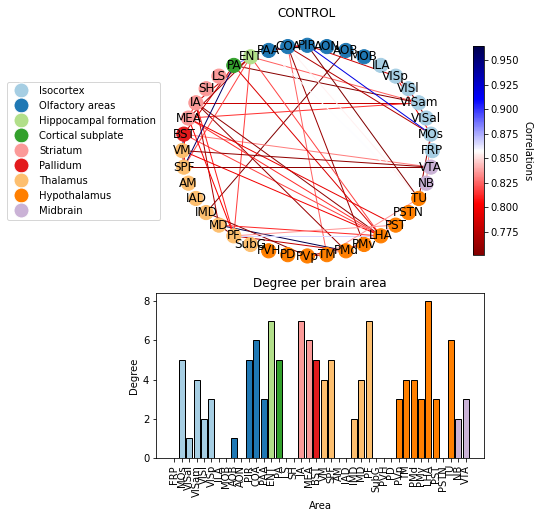

In [19]:
fig = plt.figure("control", figsize=(7, 8))
plt.subplots_adjust(left=0.25)
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')
# plot graph
ax0 = fig.add_subplot(axgrid[0:3, :])

plot_graph(G=G_control,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='CONTROL',
          edge_cmap = plt.cm.get_cmap('seismic_r'))

colors_dict = get_colors(G_control, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
areas = sorted(list(G_control.nodes()), key = allen_order.index)
degrees = [G_control.degree()[area] for area in areas]
# plot degrees
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees)

for idx, color in enumerate(get_colors(G_control, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

legend_elements = [Line2D([0], [0], marker='o', color='w', label=area,
                          markerfacecolor=colors_dict[area], markersize=15) \
                   for area in colors_dict.keys()]

# Create the legend
ax0.legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.03,0.5))

# colorbar
weights = [G_control[u][v]['weight'] for u, v in G_control.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin = min(weights)
vmax = max(weights)
sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

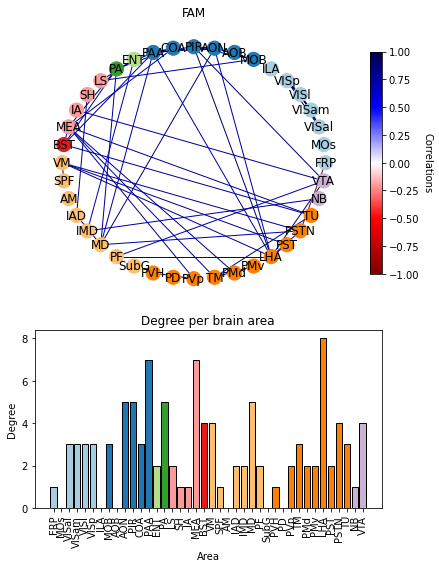

In [20]:
fig = plt.figure("fam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_fam,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='FAM',
          edge_cmap = edge_cmap)

areas = sorted(list(G_fam.nodes()), key = allen_order.index)
degrees = [G_fam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_fam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
# colorbar
weights = [G_fam[u][v]['weight'] for u, v in G_fam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

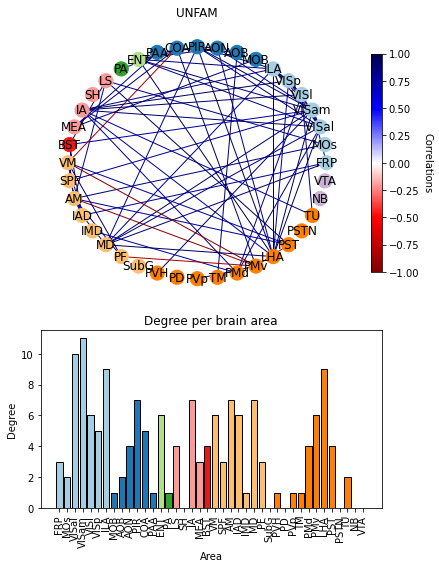

In [21]:
fig = plt.figure("unfam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_unfam,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='UNFAM',
          edge_cmap=edge_cmap)

areas = sorted(list(G_unfam.nodes()), key = allen_order.index)
degrees = [G_unfam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_unfam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

# colorbar
weights = [G_unfam[u][v]['weight'] for u, v in G_unfam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

## Graphs with nodes identified through PLS

In [22]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_BL_woF2000.npy', allow_pickle=True)

In [23]:
pls_sig_areas

array(['Accessory olfactory bulb', 'Anterior amygdalar area',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Cortical amygdalar area', 'Dorsal premammillary nucleus',
       'Medial amygdalar nucleus', 'Parataenial nucleus',
       'Periventricular hypothalamic nucleus posterior part',
       'Posterior amygdalar nucleus', 'Preparasubthalamic nucleus',
       'Ventral premammillary nucleus'], dtype='<U51')

In [24]:
G_control_pls = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.7, correlations='one')
G_fam_pls = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.7, correlations='one')
G_unfam_pls = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.7, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'CONTROL'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

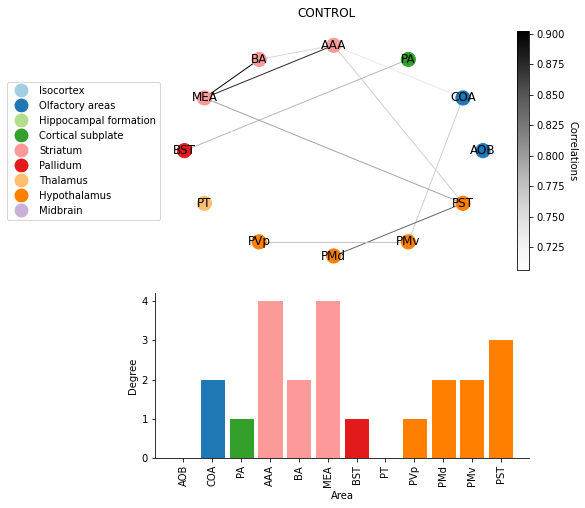

In [25]:
fig_graph_degrees(G=G_control_pls, title='CONTROL', volumes=volumes)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'FAM'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

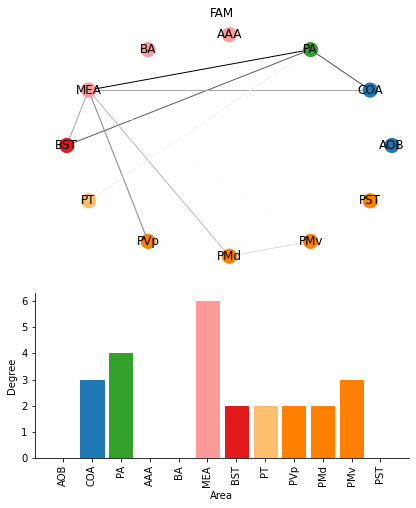

In [26]:
fig_graph_degrees(G=G_fam_pls, title='FAM', volumes=volumes, show_legend=False, show_colorbar=False)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'UNFAM'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

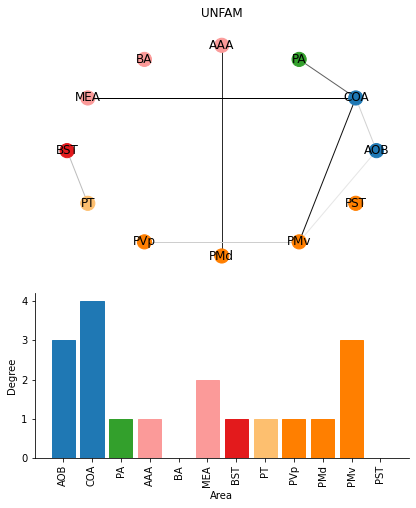

In [27]:
fig_graph_degrees(G=G_unfam_pls, title='UNFAM', volumes=volumes, show_legend=False, show_colorbar=False)

## Save significant areas

In [28]:
ordered_areas = sorted(sig_areas_ncells_ttest, 
                       key = list(volumes[volumes['st_level']==8]['safe_name'])
.index)
dictionary_labels = {volumes.loc[volumes['safe_name'] == area]['acronym'].values[0]:area\
                     for area in ordered_areas}
df_areas = pd.DataFrame.from_dict(dictionary_labels, orient='index')
df_areas.columns = ['area']
# df_areas.to_csv('significant_areas.csv')

## Look at betweenness for graphs

Text(0, 0.5, 'Average Betweenness Centrality')

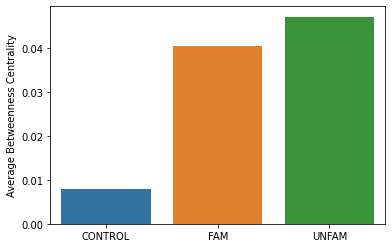

In [29]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

Text(0, 0.5, 'Average Betweenness Centrality')

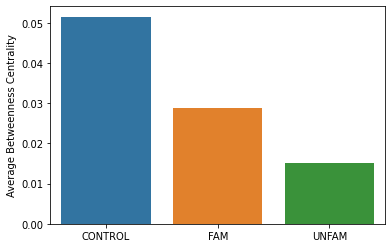

In [30]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

In [31]:
def plot_betweenness(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= betweenness)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Betweenness")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

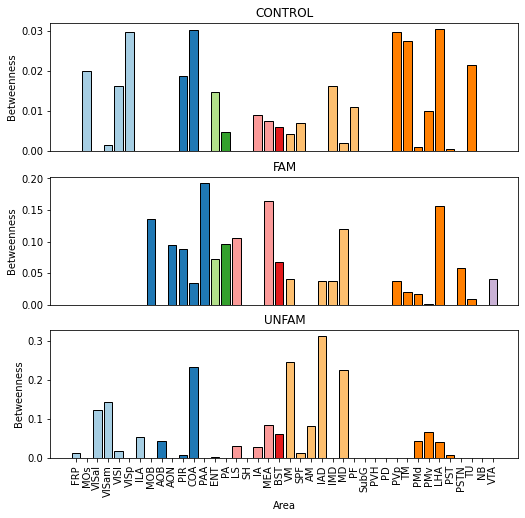

In [32]:
plot_betweenness(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

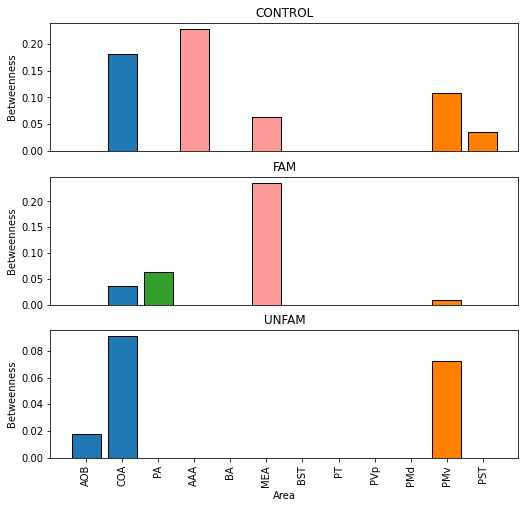

In [33]:
plot_betweenness(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)


## Order the betweenness

In [34]:
# graphs = [G_control, G_fam, G_unfam]
# graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
# # create tables
# allen_order = list(volumes[volumes['st_level']==8]['acronym'])
# df_levels = upls.create_df_levels(volumes)
# sort=True
# # create figure
# fig, axes = plt.subplots(3,1, figsize=(10, 8))
# plt.subplots_adjust(left=0.25)
# for i, G in enumerate(graphs):
#     colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
#     if sort:
#         betweenness = nx.betweenness_centrality(G)
#         sorted_betweenness = sorted(betweenness.items(), key=lambda x:x[1], reverse=True)
#         betweenness = list(dict(sorted_betweenness).values())
#         areas = list(dict(sorted_betweenness).keys())
#     else:
#         areas = sorted(list(G.nodes()), key = allen_order.index)
#         betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

#     # plot degrees
#     axes[i].bar(x= areas, 
#             height= betweenness)

#     for idx, color in enumerate(get_colors(G, 
#                                            df_levels=df_levels, 
#                                            order=allen_order,
#                                            sorting=True,
#                                            volumes=volumes)[0]):
#         axes[i].get_children()[idx].set_color(color) 
#         axes[i].get_children()[idx].set_edgecolor('black')
#     axes[i].set_title(graphs_titles[i])
#     axes[i].set_ylabel("Betweenness")
#     axes[i].set_xlabel('')
#     if i in [0,1]:
#         axes[i].set_xticks([])
# axes[2].set_xlabel("Area")
# axes[2].tick_params(axis='x', labelrotation=90)

## Look at degree centrality


The degree centrality for a node v is the fraction of nodes it is connected to.

Text(0, 0.5, 'Average degree Centrality')

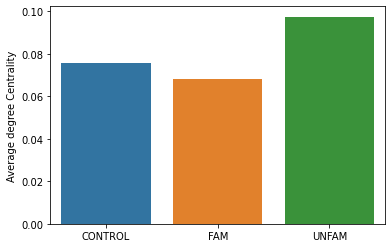

In [35]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'CONTROL': [np.mean(list(degree_centrality[0].values()))], 
                                'FAM': [np.mean(list(degree_centrality[1].values()))],
                                'UNFAM': [np.mean(list(degree_centrality[2].values()))]})
sns.barplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

Text(0, 0.5, 'Average degree Centrality')

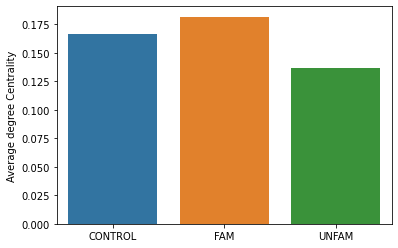

In [36]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'CONTROL': [np.mean(list(degree_centrality[0].values()))], 
                                'FAM': [np.mean(list(degree_centrality[1].values()))],
                                'UNFAM': [np.mean(list(degree_centrality[2].values()))]})
sns.barplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

In [37]:
def plot_degree_centrality(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        degree_centrality = [nx.degree_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= degree_centrality)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Degree Centrality")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

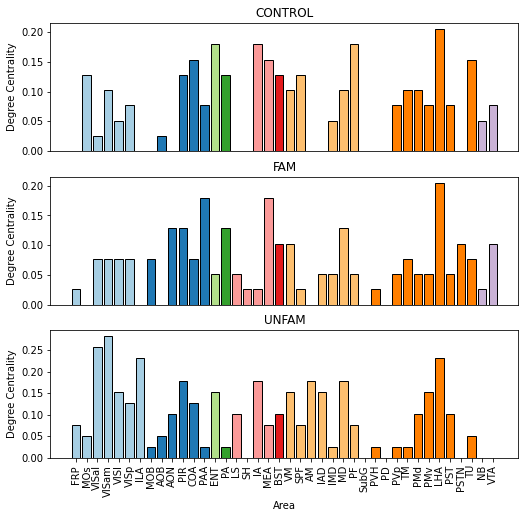

In [38]:
plot_degree_centrality(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

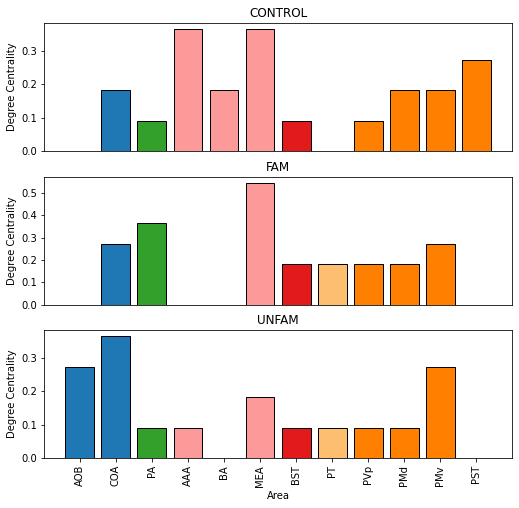

In [39]:
plot_degree_centrality(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)

## Efficiency

The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The average global efficiency of a graph is the average efficiency of all pairs of nodes

Text(0, 0.5, 'Global efficiency')

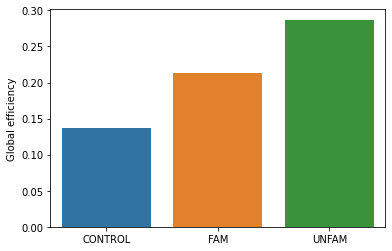

In [40]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

Text(0, 0.5, 'Global efficiency')

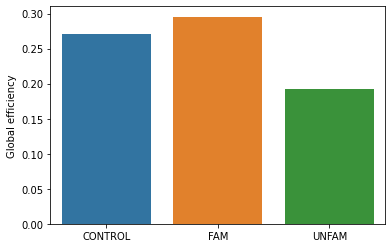

In [41]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

## Clustering

For weighted graphs, there are several ways to define clustering [1]. the one used here is defined as the geometric average of the subgraph edge weights [2],

Text(0, 0.5, 'Clustering')

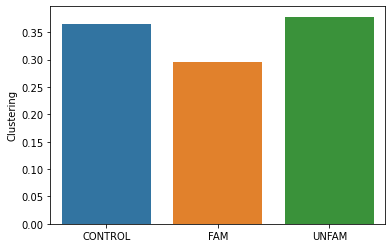

In [42]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

Text(0, 0.5, 'Clustering')

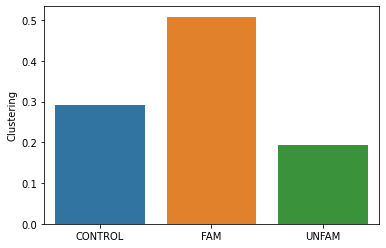

In [43]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

In [44]:
def plot_clustering(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        clustering = [nx.clustering(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= clustering)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Clustering Coefficient")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

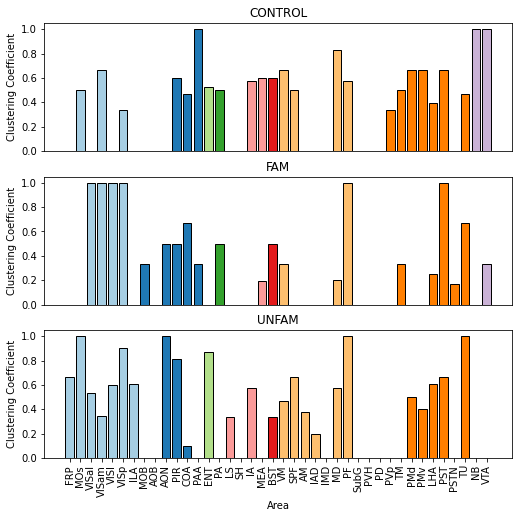

In [45]:
plot_clustering(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

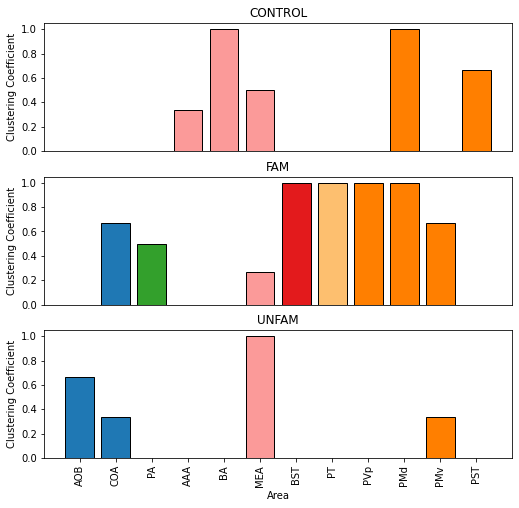

In [46]:
plot_clustering(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)

## Rich club coefficient
Returns the rich-club coefficient of the graph G.

For each degree k, the rich-club coefficient is the ratio of the number of actual to the number of potential edges for nodes with degree greater than k

Text(0, 0.5, 'Rich Club Coefficient')

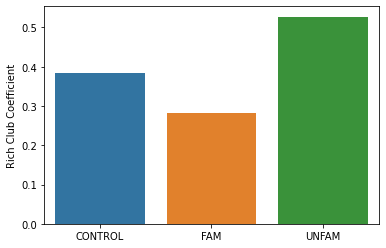

In [47]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False) for G in graphs]
df_rich_club_coefficient = pd.DataFrame({'CONTROL': [np.mean(list(rich_club_coefficient[0].values()))], 
                                'FAM': [np.mean(list(rich_club_coefficient[1].values()))],
                                'UNFAM': [np.mean(list(rich_club_coefficient[2].values()))]})
sns.barplot(data=df_rich_club_coefficient, ax=axes)
axes.set_ylabel('Rich Club Coefficient')

Text(0, 0.5, 'Rich Club Coefficient')

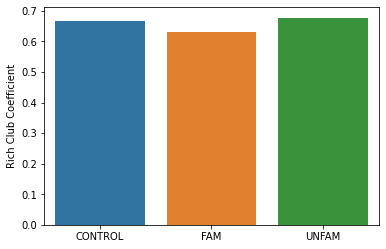

In [48]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False) for G in graphs]
df_rich_club_coefficient = pd.DataFrame({'CONTROL': [np.mean(list(rich_club_coefficient[0].values()))], 
                                'FAM': [np.mean(list(rich_club_coefficient[1].values()))],
                                'UNFAM': [np.mean(list(rich_club_coefficient[2].values()))]})
sns.barplot(data=df_rich_club_coefficient, ax=axes)
axes.set_ylabel('Rich Club Coefficient')

In [49]:
# def plot_rich_club_coefficient(graphs, volumes):
#     graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
#     # create tables
#     allen_order = list(volumes[volumes['st_level']==8]['acronym'])
#     df_levels = upls.create_df_levels(volumes)

#     # create figure
#     fig, axes = plt.subplots(3,1, figsize=(10, 8))
#     plt.subplots_adjust(left=0.25)
#     for i, G in enumerate(graphs):
#         colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
#         areas = sorted(list(G.nodes()), key = allen_order.index)
#         rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False)[G.degree[area]] for area in areas]
#         # reformat rich club coefficient
#         # first find degree for each area
#         degree = []

#         # plot degrees
#         axes[i].bar(x= areas, 
#                 height= rich_club_coefficient)

#         for idx, color in enumerate(get_colors(G, 
#                                                df_levels=df_levels, 
#                                                order=allen_order,
#                                                sorting=True,
#                                                volumes=volumes)[0]):
#             axes[i].get_children()[idx].set_color(color) 
#             axes[i].get_children()[idx].set_edgecolor('black')
#         axes[i].set_title(graphs_titles[i])
#         axes[i].set_ylabel("Rich Club coefficient")
#         axes[i].set_xlabel('')
#         if i in [0,1]:
#             axes[i].set_xticks([])
#     axes[2].set_xlabel("Area")
#     axes[2].tick_params(axis='x', labelrotation=90)

## Small-World coefficient
Functions for estimating the small-world-ness of graphs.

A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

For more information, see the Wikipedia article on small-world network [1].

### Sigma

Returns the small-world coefficient (sigma) of the given graph.

The small-world coefficient is defined as: sigma = C/Cr / L/Lr where C and L are respectively the average clustering coefficient and average shortest path length of G. Cr and Lr are respectively the average clustering coefficient and average shortest path length of an equivalent random graph.

A graph is commonly classified as small-world if sigma>1.

In [49]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control, G_fam, G_unfam]
# # calculate the small world coefficient on the largest connected component
# sigma = [nx.sigma(G.subgraph(max(nx.connected_components(G), key=len)).copy(), niter=10) for G in graphs]
# df_sigma = pd.DataFrame({'CONTROL': [sigma[0]], 
#                                 'FAM': [sigma[1]],
#                                 'UNFAM': [sigma[2]]})
# sns.barplot(data=df_sigma, ax=axes)
# axes.set_ylabel('Small World Coefficient (sigma)')

In [50]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
# # calculate the small world coefficient on the largest connected component
# sigma = [nx.sigma(G.subgraph(max(nx.connected_components(G), key=len)).copy(), niter=10) for G in graphs]
# df_sigma = pd.DataFrame({'CONTROL': [sigma[0]], 
#                                 'FAM': [sigma[1]],
#                                 'UNFAM': [sigma[2]]})
# sns.barplot(data=df_sigma, ax=axes)
# axes.set_ylabel('Small World Coefficient (sigma)')

### Omega

Returns the small-world coefficient (omega) of a graph

The small-world coefficient of a graph G is:

omega = Lr/L - C/Cl

where C and L are respectively the average clustering coefficient and average shortest path length of G. Lr is the average shortest path length of an equivalent random graph and Cl is the average clustering coefficient of an equivalent lattice graph.

The small-world coefficient (omega) measures how much G is like a lattice or a random graph. Negative values mean G is similar to a lattice whereas positive values mean G is a random graph. Values close to 0 mean that G has small-world characteristics.

In [51]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control, G_fam, G_unfam]
# # calculate the small world coefficient on the largest connected component
# omega = [nx.omega(G.subgraph(max(nx.connected_components(G), key=len)).copy()) for G in graphs]
# df_omega = pd.DataFrame({'CONTROL': [omega[0]], 
#                                 'FAM': [omega[1]],
#                                 'UNFAM': [omega[2]]})
# sns.barplot(data=df_omega, ax=axes)
# axes.set_ylabel('Small World Coefficient (omega)')

In [52]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
# # calculate the small world coefficient on the largest connected component
# omega = [nx.omega(G.subgraph(max(nx.connected_components(G), key=len)).copy()) for G in graphs]
# df_omega = pd.DataFrame({'CONTROL': [omega[0]], 
#                                 'FAM': [omega[1]],
#                                 'UNFAM': [omega[2]]})
# sns.barplot(data=df_omega, ax=axes)
# axes.set_ylabel('Small World Coefficient (omega)')

# Analysis on Energy

In [53]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')

df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

In [54]:
G_control_energy = create_graph(corr_matrix_control_energy, volumes=volumes, 
                         significant_areas=sig_areas_energy_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam_energy = create_graph(corr_matrix_fam_energy,  volumes=volumes, 
                         significant_areas=sig_areas_energy_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam_energy = create_graph(corr_matrix_unfam_energy,  volumes=volumes, 
                         significant_areas=sig_areas_energy_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


## Graphs of positive correlations

(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:title={'center':'CONTROL'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

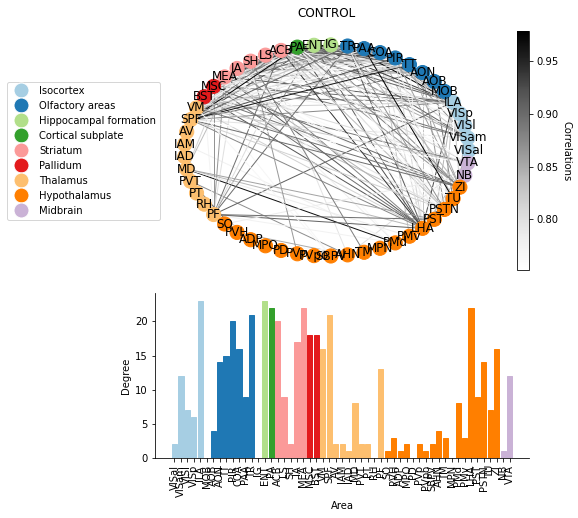

In [55]:
fig_graph_degrees(G=G_control_energy, title='CONTROL', volumes=volumes)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'FAM'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

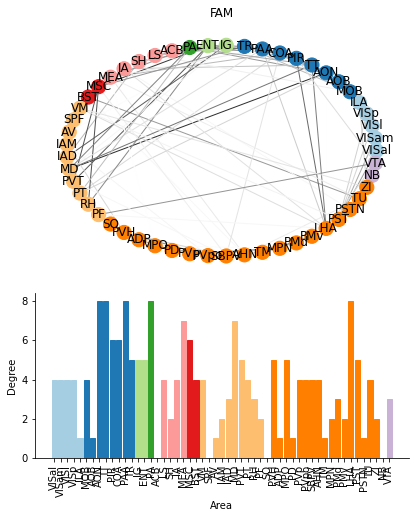

In [56]:
fig_graph_degrees(G=G_fam_energy, title='FAM', volumes=volumes, show_colorbar=False, show_legend=False)

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:title={'center':'UNFAM'}>,
 <AxesSubplot:xlabel='Area', ylabel='Degree'>)

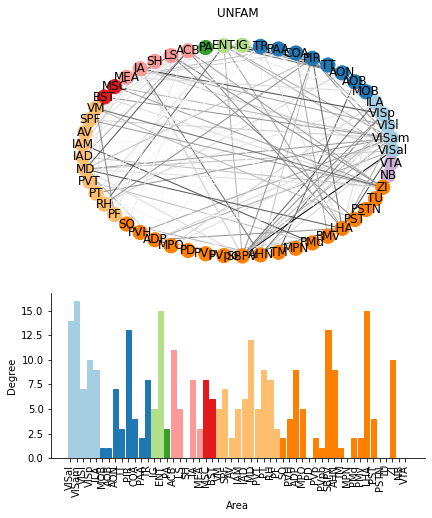

In [57]:
fig_graph_degrees(G=G_unfam_energy, title='UNFAM', volumes=volumes, show_colorbar=False, show_legend=False)

## Histogram degrees

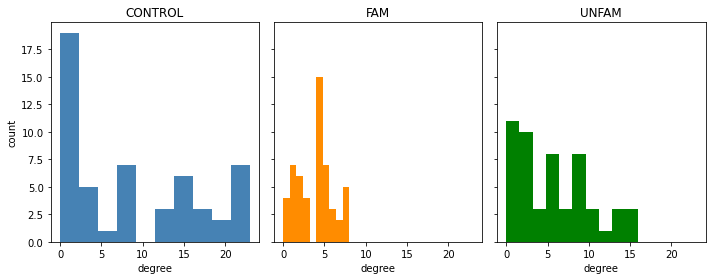

In [58]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control_energy.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam_energy.degree).values()),
            color='darkorange')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam_energy.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()

## Boxplot degrees

Text(0, 0.5, 'Degree')

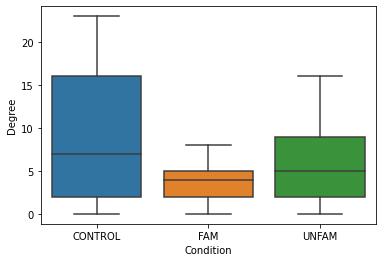

In [59]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control_energy.degree).values()), 
                           'FAM': list(dict(G_fam_energy.degree).values()), 
                           'UNFAM':list(dict(G_unfam_energy.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Overall correlations

Text(0.5, 0.98, 'Correlation distribution of significant areas')

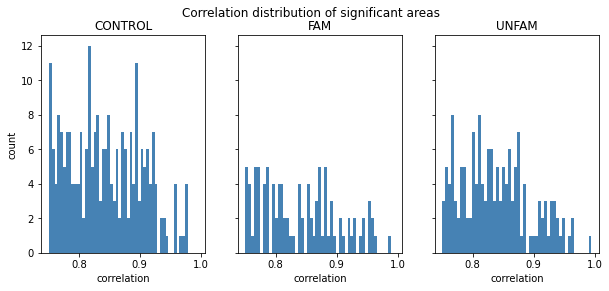

In [60]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control_energy, G_fam_energy, G_unfam_energy]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue', bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlation distribution of significant areas')

Text(0, 0.5, 'count')

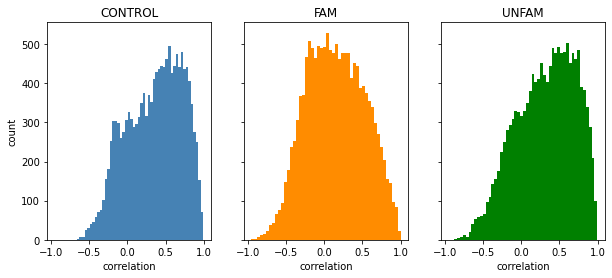

In [61]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_energy, 
                          corr_matrix_fam_energy, 
                          corr_matrix_unfam_energy]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')

## Betweenness centrality

Text(0, 0.5, 'Average Betweenness Centrality')

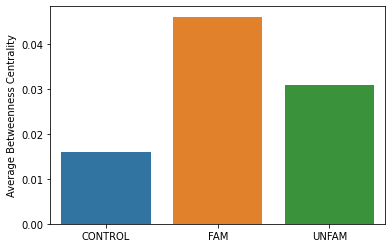

In [62]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_energy, G_fam_energy, G_unfam_energy]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')